(2500, 2500)


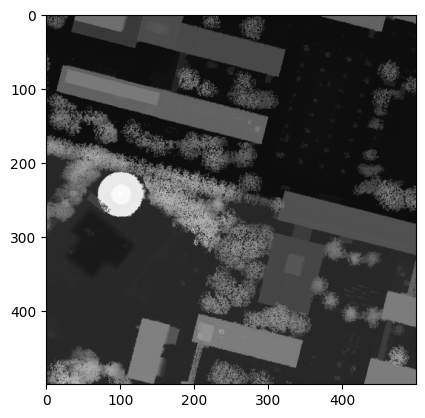

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from pyproj import CRS
from pyproj import Transformer

import cv2


"""
    NOTE: I flipped longitude and latitude in most cases.
"""


"""This section loads in the four tiff files that specify the Tech_Uni_Denmark campus"""
directory = 'DSM_6188_720_2x2/'
name = 'DSM_1km_'
im1_TL = Image.open(directory + name + '6188_720_TL.tif')
im2_TR = Image.open(directory + name + '6188_721_TR.tif')
im3_BL = Image.open(directory + name + '6187_720_BL.tif')
im4_BR = Image.open(directory + name + '6187_721_BR.tif')
(row_len, col_len) = np.asarray(im1_TL).shape
im_arr = np.zeros((row_len * 2, col_len * 2))
im_arr[0:row_len, 0:col_len] = np.asarray(im1_TL)
im_arr[0:row_len, col_len:col_len*2] = np.asarray(im2_TR)

im_arr[row_len:2*row_len, 0:col_len] = np.asarray(im3_BL)
im_arr[row_len:2*row_len, col_len:col_len*2] = np.asarray(im4_BR)
plt.imshow(im_arr[3500:4000, 1000:1500], cmap='gray')
print(np.asarray(im1_TL).shape)
# print(im_arr[3500, 1000:1200])

In [3]:
"""This section tests the pyproj.Transformer function"""
# the tiff data from https://dataforsyningen.dk/data/928 use the EPSG:25832 coordinate system.
TL_25832_coord_x, TL_25832_coord_y = 6189000, 720000  # global var, top left of the 2kmx2km block, (x, y) coord
idx_per_meter = 0.4  # global var

crs_4326 = CRS.from_epsg(4326)  # standard longitude latitude coordinate system
crs_25832 = CRS.from_epsg(25832)  # used in tiff data
transformer = Transformer.from_crs(crs_4326, crs_25832)  # always_xy=False is default, always_xy=True doesn't work
print(transformer.transform(55.78575, 12.521488))  # Tech_Uni_Denmark's loc

(720789.8700294881, 6187848.282714585)


2879 1975


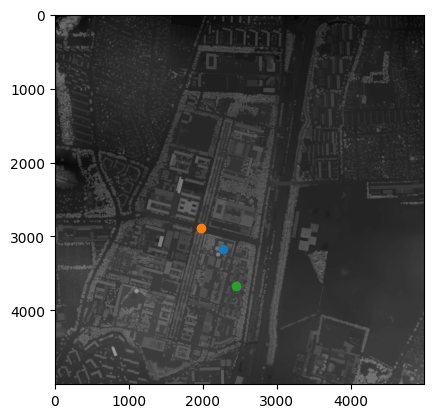

In [4]:
"""This section contains the transformation from longitude/lattitude to array index"""
def long_lat_to_arr_idx(long, lat, from_EPSG=4326, to_EPSG=25832):
    transform_obj = Transformer.from_crs(from_EPSG, to_EPSG)
    dest_x, dest_y = transform_obj.transform(long, lat)
    # converting from (x, y) to (row, col)
    row_arr, col_arr = (TL_25832_coord_x - dest_y) / idx_per_meter, (dest_x - TL_25832_coord_y) / idx_per_meter
    return int(np.round(row_arr)), int(np.round(col_arr))

DTU_4326_x, DTU_4326_y = 55.78575, 12.521488  # longitude and latitude of Tech_Uni_Denmark (DTU)
(DTU_25832_coord_row, DTU_25832_coord_col) = long_lat_to_arr_idx(long=DTU_4326_x, lat=DTU_4326_y)  # row, col of DTU
# r_temp, c_temp = (TL_25832_coord_x - 6188000) / idx_per_meter, (721000 - TL_25832_coord_y) / idx_per_meter

# radio waves transmitter location (row, col)
Tx_4326_x, Tx_4326_y = 55.784663, 12.523303
Tx_25832_coord_row, Tx_25832_coord_col = long_lat_to_arr_idx(Tx_4326_x, Tx_4326_y, from_EPSG=4326, to_EPSG=25832)
r_temp1, c_temp1 = long_lat_to_arr_idx(long=55.782805, lat=12.524276)
# (r_temp1, c_temp1) define a random point
print(DTU_25832_coord_row, DTU_25832_coord_col)
plt.scatter([Tx_25832_coord_col], [Tx_25832_coord_row])
plt.scatter([DTU_25832_coord_col], [DTU_25832_coord_row])
plt.scatter([c_temp1], [r_temp1])
t = 500
plt.imshow(im_arr, cmap='gray')

get_rotation_angle printing... ...
receiver longitude  55.785750   receiver latitude  12.521488
angle using EPSG 25832:  2.376605
angle using array idx:  2.374932
... ...get_rotation_angle finished printing



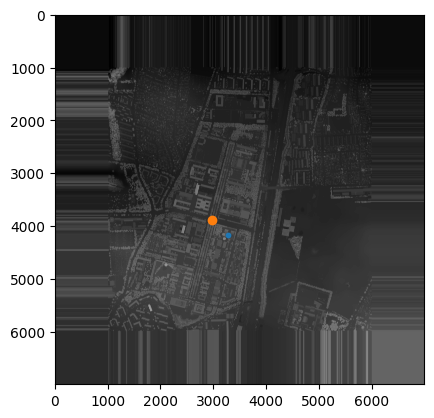

In [5]:
"""This section gives the angle of rotation based on the (row,col) difference between transmitter (Tx_25832_coord_row/col) and user (long/lat_centre)"""
def get_rotation_angle(long_centre, lat_centre):
    """Returns the angle difference between the y-axis (with axes centred at Tx antenna) and the receiver. The sign is the rotational direction (positive == rotate counterclockwise, negative == rotate clockwise)"""
    print('get_rotation_angle printing... ...')
    print('receiver longitude  {:f}'.format(long_centre), '  receiver latitude  {:f}'.format(lat_centre))
    transform_obj = Transformer.from_crs(4326, 25832)
    Tx_x, Tx_y = transform_obj.transform(Tx_4326_x, Tx_4326_y)  # outputs are in terms of EPSG 25832
    Rx_x, Rx_y = transform_obj.transform(long_centre, lat_centre)  # outputs are in terms of EPSG 25832
    dx, dy = Rx_x - Tx_x, Rx_y - Tx_y
    better_angle = np.angle(dx + 1j * dy)
    print('angle using EPSG 25832:  {:f}'.format(better_angle))
    r, c = long_lat_to_arr_idx(long=long_centre, lat=lat_centre, from_EPSG=4326, to_EPSG=25832)
    r_diff, c_diff = Tx_25832_coord_row - r, c - Tx_25832_coord_col
    # inverted the r_diff coordinate to convert from (row, col) (row 0 starts top left) to (x, y) (which starts bottom left)
    worse_ang = np.angle(c_diff + 1j * r_diff)
    print('angle using array idx:  {:f}'.format(worse_ang))
    print('... ...get_rotation_angle finished printing\n')
    """this is the better angle, calculated using 25832 coordinates"""
    ang = better_angle
    if np.pi / 2 <= ang <= np.pi:  # quadrant II
        return np.pi / 2 - np.abs(ang)  # this is correct (provisionally)
    elif -np.pi <= ang <= -np.pi / 2:  # quadrant III
        return np.abs(ang) - 3 * np.pi / 2  # this is correct (provisionally)
    elif 0 <= ang <= np.pi / 2:  # quadrant I
        return np.pi / 2 - np.abs(ang)  # this is correct (provisionally)
    elif -np.pi / 2 <= ang <= 0:  # quadrant IV
        return np.pi / 2 + np.abs(ang)
    print("ERROR: get_rotation_angle did not return angle")

angle = get_rotation_angle(long_centre=DTU_4326_x, lat_centre=DTU_4326_y)

"""Padding image in preparation for rotation"""
rrr, ccc = im_arr.shape
pad_fraction = 0.2
im_arr_padded = np.pad(array=im_arr, pad_width=(int(rrr * pad_fraction), int(ccc * pad_fraction)), mode='edge')
# plotting transmitter (x,y) and test point (x,y), which is the DTU loc as specified by Google
plt.scatter(Tx_25832_coord_col + rrr * pad_fraction, Tx_25832_coord_row + rrr * pad_fraction, s=10)
plt.scatter(DTU_25832_coord_col + rrr * pad_fraction, DTU_25832_coord_row + rrr * pad_fraction)
plt.imshow(im_arr_padded, cmap='gray')
# after rotation, these two points (yellow, blue) should be aligned vertically

get_rotation_angle printing... ...
receiver longitude  55.785750   receiver latitude  12.521488
angle using EPSG 25832:  2.376605
angle using array idx:  2.374932
... ...get_rotation_angle finished printing

get_rotation_angle printing... ...
receiver longitude  55.785750   receiver latitude  12.521488
angle using EPSG 25832:  2.376605
angle using array idx:  2.374932
... ...get_rotation_angle finished printing

[3274.69474295 3751.85602819]


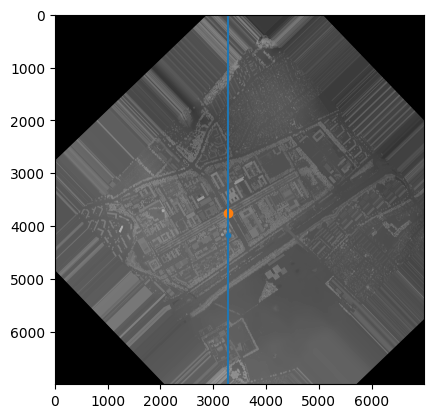

In [6]:
"""Functions to rotate the image and rotate the receiver's location"""
def rotate_img_about_antenna(img_arr, long_centre, lat_centre, scale=1.0, pad_frac=pad_fraction):
    """Rotates the image about the antenna."""
    # img_arr should be padded; long_centre, lat_centre are the longitude and latitude of the receiver. Rotate image such that the line connecting the user and transmitter is vertical.
    rot_matrix = get_rotation_mat(long_centre, lat_centre, scale=scale, pad_frac=pad_frac)
    (h, w) = img_arr.shape[:2]
    rotated = cv2.warpAffine(img_arr, rot_matrix, (w, h))
    return rotated

def rotate_point_about_antenna(long_centre, lat_centre, scale=1.0, pad_frac=pad_fraction, orig_img_shape=5000, rot_matrix=None):
    # orig_img_shape=5000 using im_arr.shape
    """NOTE: rotates the point (x,y) about the antenna, not the (row,col). Need to do plt.scatter(point[1], point[0]) (i.e., flip the points). DOES NOT RETURN int array, therefore must int(output) when treating output as arr idx."""
    if rot_matrix is None:
        rot_matrix = get_rotation_mat(long_centre, lat_centre, scale=scale, pad_frac=pad_frac)
    point = np.ones(3)
    # long_lat_to_arr_idx returns the array index, hence we need to transform the indices
    (point[0], point[1]) = long_lat_to_arr_idx(long=long_centre, lat=lat_centre, from_EPSG=4326, to_EPSG=25832)
    # adding the padding (i.e., shifting) and swapping to (x,y) for rotation
    (point[0], point[1]) = (point[1] + orig_img_shape * pad_frac, point[0] + orig_img_shape * pad_frac)
    # transforming the shifted (x,y) location using the rotation matrix. Provides (col, row) indexing into padded img
    return np.matmul(rot_matrix, point.T)

def get_rotation_mat(long_centre, lat_centre, scale=1.0, pad_frac=pad_fraction, orig_img_shape=5000):
    # long_centre, lat_centre: longitude and latitude of the receiver
    rot_angle = (get_rotation_angle(long_centre, lat_centre)) * 180 / np.pi # radian to degree
    # perhaps subtract 0.025 rad from rot_angle to increase accuracy
    # centre is the antenna, accounting for padding
    rot_matrix = cv2.getRotationMatrix2D(center=(Tx_25832_coord_col + orig_img_shape * pad_frac, Tx_25832_coord_row + orig_img_shape * pad_frac), angle=rot_angle, scale=scale)
    return rot_matrix

plt.imshow(rotate_img_about_antenna(img_arr=im_arr_padded, long_centre=DTU_4326_x, lat_centre=DTU_4326_y), cmap='gray')
DTU_25832_padded = rotate_point_about_antenna(long_centre=DTU_4326_x, lat_centre=DTU_4326_y)
plt.scatter([Tx_25832_coord_col + rrr * pad_fraction], [Tx_25832_coord_row + rrr * pad_fraction], s=10)

print(DTU_25832_padded)
plt.scatter(DTU_25832_padded[0], DTU_25832_padded[1])
plt.axvline(Tx_25832_coord_col + rrr * pad_fraction)  # rrr is the shape of the image (im_arr) without padding
plt.savefig('test.pdf')

get_rotation_angle printing... ...
receiver longitude  55.785750   receiver latitude  12.521488
angle using EPSG 25832:  2.376605
angle using array idx:  2.374932
... ...get_rotation_angle finished printing

[3274.69474295 3751.85602819]
get_rotation_angle printing... ...
receiver longitude  55.785750   receiver latitude  12.521488
angle using EPSG 25832:  2.376605
angle using array idx:  2.374932
... ...get_rotation_angle finished printing



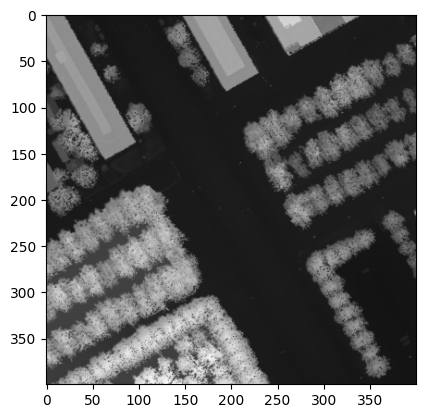

In [7]:
# testing the array index using the location of DTU
DTU_25832_padded = rotate_point_about_antenna(long_centre=DTU_4326_x, lat_centre=DTU_4326_y)
print(DTU_25832_padded)

temp_row, temp_col = int(DTU_25832_padded[1]), int(DTU_25832_padded[0])
disp = 200
im_arr_padded_rotated = rotate_img_about_antenna(img_arr=im_arr_padded, long_centre=DTU_4326_x, lat_centre=DTU_4326_y)
plt.imshow(im_arr_padded_rotated[temp_row-disp:temp_row+disp, temp_col-disp:temp_col+disp], cmap='gray')
# the image should show the centre of DTU according to Google in the centre of the image with the south (bottom) facing the antenna
# plt.scatter(disp, disp)

get_rotation_angle printing... ...
receiver longitude  55.780073   receiver latitude  12.520112
angle using EPSG 25832:  -1.893345
angle using array idx:  -1.893238
... ...get_rotation_angle finished printing

get_rotation_angle printing... ...
receiver longitude  55.780073   receiver latitude  12.520112
angle using EPSG 25832:  -1.893345
angle using array idx:  -1.893238
... ...get_rotation_angle finished printing



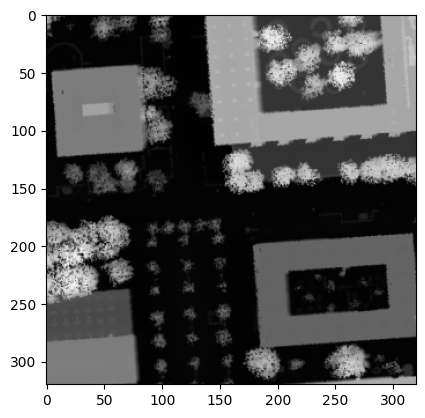

In [8]:
def testing_by_quadrant(padded_img, test_lon, test_lat):
    # rotated image:
    rot_img = rotate_img_about_antenna(img_arr=padded_img, long_centre=test_lon, lat_centre=test_lat, scale=1.0, pad_frac=pad_fraction)
    # rotated coordinates of the receiver, using the padded image's col/row system:
    col_rot, row_rot = rotate_point_about_antenna(long_centre=test_lon, lat_centre=test_lat, scale=1.0, pad_frac=pad_fraction, orig_img_shape=5000, rot_matrix=None)
    return rot_img[int(row_rot-arr_dimension/2):int(row_rot+arr_dimension/2),
                   int(col_rot-arr_dimension/2):int(col_rot+arr_dimension/2)]


"""testing quadrant III"""
test_long3, test_lati3 = 55.780073, 12.520112   # corresponds to 0.png
# need the rotated image, centre of the user (row, col) and the limits of the box (using the indices per meter parameter)

arr_dimension = 256 * 1.25

img_chip_test3 = testing_by_quadrant(im_arr_padded, test_long3, test_lati3)
plt.imshow(img_chip_test3, cmap='gray')

get_rotation_angle printing... ...
receiver longitude  55.784886   receiver latitude  12.516722
angle using EPSG 25832:  3.132355
angle using array idx:  3.131922
... ...get_rotation_angle finished printing

get_rotation_angle printing... ...
receiver longitude  55.784886   receiver latitude  12.516722
angle using EPSG 25832:  3.132355
angle using array idx:  3.131922
... ...get_rotation_angle finished printing



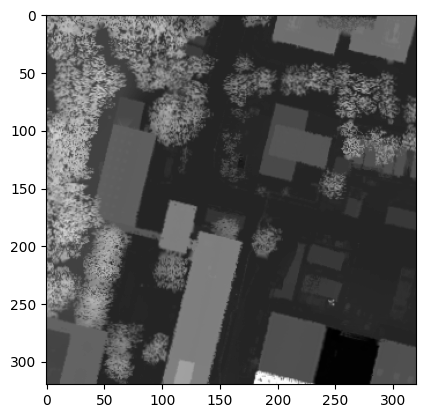

In [9]:
"""Testing quadrant II"""
test_long2, test_lati2 = 55.784886, 12.516722  # another test point

# square chip, rotated
img_chip_test2 = testing_by_quadrant(im_arr_padded, test_long2, test_lati2)

plt.imshow(img_chip_test2, cmap='gray')

get_rotation_angle printing... ...
receiver longitude  55.783327   receiver latitude  12.524524
angle using EPSG 25832:  -1.044336
angle using array idx:  -1.043065
... ...get_rotation_angle finished printing

get_rotation_angle printing... ...
receiver longitude  55.783327   receiver latitude  12.524524
angle using EPSG 25832:  -1.044336
angle using array idx:  -1.043065
... ...get_rotation_angle finished printing



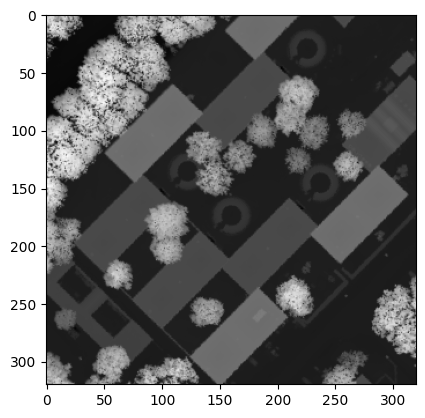

In [10]:
"""testing quadrant IV"""
test_long4, test_lati4 = 55.783327, 12.524524

# square chip, rotated
img_chip_test4 = testing_by_quadrant(im_arr_padded, test_long4, test_lati4)

plt.imshow(img_chip_test4, cmap='gray')

get_rotation_angle printing... ...
receiver longitude  55.786968   receiver latitude  12.525550
angle using EPSG 25832:  1.119373
angle using array idx:  1.118748
... ...get_rotation_angle finished printing

get_rotation_angle printing... ...
receiver longitude  55.786968   receiver latitude  12.525550
angle using EPSG 25832:  1.119373
angle using array idx:  1.118748
... ...get_rotation_angle finished printing



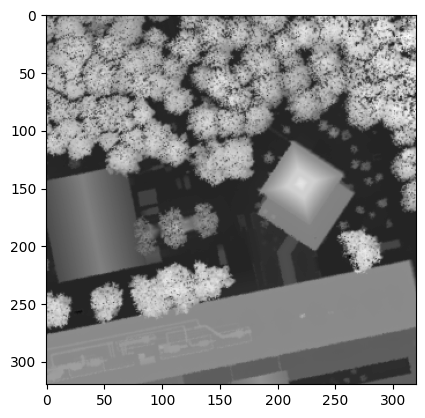

In [11]:
"""Testing quadrant I"""
test_long1, test_lati1 = 55.786968, 12.525550

# square chip, rotated
img_chip_test1 = testing_by_quadrant(im_arr_padded, test_long1, test_lati1)
plt.imshow(img_chip_test1, cmap='gray')

get_rotation_angle printing... ...
receiver longitude  55.781590   receiver latitude  12.511445
angle using EPSG 25832:  -2.659775
angle using array idx:  -2.659594
... ...get_rotation_angle finished printing

get_rotation_angle printing... ...
receiver longitude  55.781590   receiver latitude  12.511445
angle using EPSG 25832:  -2.659775
angle using array idx:  -2.659594
... ...get_rotation_angle finished printing



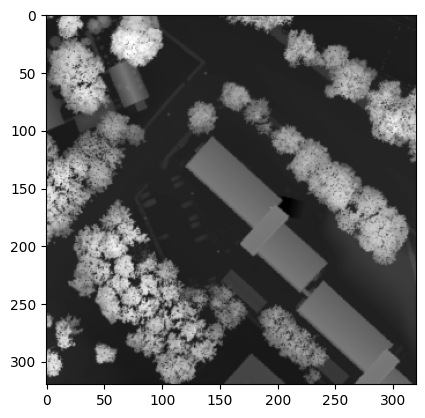

In [12]:
test_edge_long1, test_edge_lat1 = 55.781590, 12.511445

img_chip_test_ = testing_by_quadrant(im_arr_padded, test_edge_long1, test_edge_lat1)
plt.imshow(img_chip_test_, cmap='gray')